<h1 style="text-align: center;"> This notebook provides functions for calculating an importance of features and drawing Figure 10 from the paper
    <h2 style="text-align: center;"> <b>"Impact of Pre- and Post-Processing Steps for Supervised Classification of Colorectal Cancer in Hyperspectral Images" </b> </h2>
</h1>
<h3> It contains code for: <br>
   - Figure 10 (feature importance for different models with different scaling types. Binary case) <br>
   - Experiments with shap and eli5 libraries to get the most important features  
    
</h3>
<h3>
    Paper: <a href='https://www.mdpi.com/2233040'>https://www.mdpi.com/2233040 </a> <br>
    Documentation: <a href='https://git.iccas.de/MaktabiM/hsi-experiments/-/wikis/Post-processing'>https://git.iccas.de/MaktabiM/hsi-experiments/-/wikis/Post-processing </a> <br> <br>
    
    The notebook is divided into sections for simplicity
</h3>

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2023-06-20 13:44:44.251011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h1 style="text-align: center;"> Load and scale spectra (better to use 16-32 Gb memory and GPU during a set up of your server) </h1>

In [2]:
import sys
sys.path.insert(0, '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/jupyter')
from spectraUtil import SpectraUtil

paths from config ['/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/util', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/data_utils/data_loaders', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/models', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/trainers', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/data_utils', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/data_utils', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/jupyter', '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/post-processing', '/home/sc.uni-leipzig.de/mi186veva/.conda/envs/feature_importance_tf/lib/python311.zip', '/home/sc.uni-leipzig.de/mi186veva/.conda/envs/feature_importance_tf/lib/python3.11', '/home/sc.uni-leipzig.de/mi186veva/.conda/envs/feature_importance_tf/lib/python3.11/lib-dynload', '', '/home/sc.uni-leipzig.de/mi186veva/.local/lib/python3.11/site-packages', '/home/sc.uni-leipzig.de/mi186veva/.conda/envs/feature_importan

In [3]:
# get data for Figure 10
util = SpectraUtil('/work/users/mi186veva/data_1d/raw')

X_full, y_full = util.get_full_X_y()
print(X_full.shape, y_full.shape)

X, y = util.get_part_of_X_y(X_full, y_full, each_Xth_sample=10000)
print(X.shape, y.shape)

X_normalized, X_standard_scaled_T = util.get_scaled_X(X)
healthy, ill = util.get_healthy_and_ill_indexes(y)

NormalizerScaler is created
StandardScalerTransposed is created
(5791157, 92) (5791157,)
(580, 92) (580,)


In [4]:
#get 3d data from one archive for shap and eli5 
paths = glob('/work/users/mi186veva/data_3d/l2_norm/*.npz')

k_th = 5000

data = np.load(paths[0])
X_3d, y_3d = data['X'][::k_th], data['y'][::k_th]

<h1 style="text-align: center;"> Figure 10. Feature importance </h1>
<h3> Detailed description how the importance of feature is calculated is presented in Appendix A of the paper: <a href='https://www.mdpi.com/2233040'>https://www.mdpi.com/2233040 </a> </h3>

In [5]:
import sys
sys.path.insert(0, '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments') 
import config

In [ ]:
# Part 1. Functions

# Plot feature importance for one model
def plot_importance_for_model(model_folder, default_value, extreme_value, plot=False):
    print(model_folder)

    model = tf.keras.models.load_model(model_folder, custom_objects=config.CUSTOM_OBJECTS)

    features_importance = []
    features_number = config.LAST_NM - config.FIRST_NM

    for feature in range(features_number):
        input_ = np.zeros((1, 5, 5, features_number))
        input_[:] = float(default_value)
        
        input_[:, :, :, feature] = float(extreme_value)  # fill the slice of the feature with an extreme value

        features_importance.append(model.predict(input_, verbose=0)[0, 0])
    
    if plot:
        plt.scatter(np.arange(len(features_importance)), np.array(features_importance))
        plt.show()
    
    return features_importance

# Plot important features for several models simultaniously
def plot_cumulative_features(model_folders, default_value, extreme_value, column, plot=False):
    
    features_importance_cumulative = np.zeros(92)
    
    for folder in model_folders:
        features_importance = plot_importance_for_model(folder, default_value, extreme_value, plot=plot)
        features_importance_cumulative += features_importance
        
    #print(features_importance_cumulative)

    if column=='rs-based-models':
        column = 1
        
    if column=='inception-based-models':
        column = 0     
        
    for feature in np.flatnonzero(features_importance_cumulative > 0):
        ax[1, column].axvline(x = (feature * 5) + 540, color = 'b')
        ax[2, column].axvline(x = (feature * 5) + 540, color = 'b')
    
    return features_importance_cumulative

        
# Part 2. Initialize  plot 
x_labels = (np.arange(X.shape[-1]) * 5) + 540

fig, ax = plt.subplots(3, 2, figsize=(15, 15)) 
ax[0, 0].plot(x_labels, X[healthy].T, c='#440154FF')
ax[0, 0].plot(x_labels, X[ill].T, c='#FDE725FF')
ax[0, 1].plot(x_labels, X[healthy].T, c='#440154FF')
ax[0, 1].plot(x_labels, X[ill].T, c='#FDE725FF')
ax[0, 0].set_ylabel('Raw spectra', fontdict={'fontsize': 20})#, x=-0.15, y=0.2, rotation=90)
ax[0, 0].set_title('Inception-based networks', fontdict={'fontsize': 20}, y=1.1)
ax[0, 1].set_title('RS-based networks', fontdict={'fontsize': 20}, y=1.1)
ax[0, 1].set_ylabel('Reflectance in a.u.')

ax[1, 0].plot(x_labels, X_normalized[healthy].T, c='#440154FF')
ax[1, 0].plot(x_labels, X_normalized[ill].T, c='#FDE725FF')
ax[1, 1].plot(x_labels, X_normalized[healthy].T, c='#440154FF')
ax[1, 1].plot(x_labels, X_normalized[ill].T, c='#FDE725FF')
ax[1, 0].set_title('Spectra after\nNormalization', fontdict={'fontsize': 20}, x=-0.15, y=0.2, rotation=90)
ax[1, 1].set_ylabel('Reflectance in a.u.')

ax[2, 0].plot(x_labels, X_standard_scaled_T[healthy].T, c='#440154FF')
ax[2, 0].plot(x_labels, X_standard_scaled_T[ill].T, c='#FDE725FF')
ax[2, 1].plot(x_labels, X_standard_scaled_T[healthy].T, c='#440154FF')
ax[2, 1].plot(x_labels, X_standard_scaled_T[ill].T, c='#FDE725FF')
ax[2, 0].set_title('Spectra after\nStandardization', fontdict={'fontsize': 20}, x=-0.15, y=0.2, rotation=90)
ax[2, 1].set_ylabel('Reflectance in a.u.')
ax[2, 0].set_xlabel('Wavelenghts in nm')
ax[2, 1].set_xlabel('Wavelenghts in nm')

# Part 3. Plot cumulative features

# plot the most important features for Inception-based models in the left column        
inception_based_importances = plot_cumulative_features([
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception/3d_0_1_2_3/checkpoints/cp-0036/',
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception_exclude1_all/3d_0_2019_07_12_11_15_49_/checkpoints/cp-0016/',
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception_svn_every_third/3d_0_1_2_3/checkpoints/cp-0018/',
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception_exclude1_every_third/3d_0_2019_07_12_11_15_49_/checkpoints/cp-0016/'
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_inception\\3d_0_1_2_3\\checkpoints\\cp-0036\\',
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_inception_exclude1_all\\3d_0_2019_07_12_11_15_49_\\checkpoints\\cp-0016\\',
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_inception_svn_every_third\\3d_0_1_2_3\\checkpoints\\cp-0018\\'

], 0, 1000, 'inception-based-models', plot=False)

# plot the most important features for RS-based models in the right column        
rs_based_importances = plot_cumulative_features([
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_svn_every_third/3d_0_1_2_3/checkpoints/cp-0016/',
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_sample_weights_every_third/3d_0_1_2_3/checkpoints/cp-0018/',
    '/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_every_third/3d_0_1_2_3/checkpoints/cp-0016/',
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_svn_every_third\\3d_0_1_2_3\\checkpoints\\cp-0016\\',
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_sample_weights_every_third\\3d_0_1_2_3\\checkpoints\\cp-0016\\',
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_every_third\\3d_0_1_2_3\\checkpoints\\cp-0018\\',
    #'C:\\Users\\tkachenko\\Desktop\\HSI\\hsi-experiments\\logs\\CV_3d_inception_exclude1_every_third\\3d_0_2019_07_12_11_15_49_\\checkpoints\\cp-0016\\'

], 0, 1000, 'rs-based-models', plot=False)


plt.savefig(os.path.join('images', 'Figure 10.png'))
plt.show()
    
# Part 4. Plot feature importances (scatter plot) for a seperate model

# Inception-based:
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception/3d_0_1_2_3/checkpoints/cp-0036/', 0, 1000, plot=True)
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception_exclude1_all/3d_0_2019_07_12_11_15_49_/checkpoints/cp-0016/', 0, 1000, plot=True)
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception_svn_every_third/3d_0_1_2_3/checkpoints/cp-0018/', 0, 1000, plot=True)
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception_exclude1_every_third/3d_0_2019_07_12_11_15_49_/checkpoints/cp-0016/', 0, 1000, plot=True)

# RS-based:
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_svn_every_third/3d_0_1_2_3/checkpoints/cp-0016/', 0, 1000, plot=True)
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_sample_weights_every_third/3d_0_1_2_3/checkpoints/cp-0018/', 0, 1000, plot=True)
#plot_importance_for_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_every_third/3d_0_1_2_3/checkpoints/cp-0016/', 0, 1000, plot=True)


In [7]:
# show features that are important for both model groups: RS-based and Inception-based
import numpy as np

print('Features that are important for both Inception-based and RS-based models:', (np.intersect1d(np.flatnonzero(inception_based_importances > 0.), np.flatnonzero(rs_based_importances > 0.)) * 5) + 540, 'nm')
print('Indexes of the important features: ', np.intersect1d(np.flatnonzero(inception_based_importances > 0.), np.flatnonzero(rs_based_importances > 0.)))
print('---------------------------------------------------------------')
print('Indexes of the important features for Inception-based models', np.flatnonzero(inception_based_importances > 0.))
print('Indexes of the important features for RS-based models', np.flatnonzero(rs_based_importances > 0.))

Features that are important for both Inception-based and RS-based models: [605 610 875 975] nm
Indexes of the important features:  [13 14 67 87]
---------------------------------------------------------------
Indexes of the important features for Inception-based models [ 4  5  9 10 11 12 13 14 17 26 27 36 42 43 46 47 48 49 60 61 67 87]
Indexes of the important features for RS-based models [13 14 15 30 56 57 58 67 70 71 72 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 90 91]


<h1 style="text-align: center;"> Trying shap (a library for calculating the most important features) </h1>
Conclusions: The library doesn't support 3D, only 1D (or I haven't found how to make 3D work) <br>
I tried it on 1d model inception_l2_norm_all_data, which was the best for 1d case <br>
And the most important features (indexes) are, starting from the most important: 13, 8, 43, 7, 9, 44, 14, 42... (the last cell of shap part) <br>
So, surprisingly feature 13 and 14 are there! Which proofs that our straight-forward approach, presented in Appendix A works quite well

In [5]:
import shap

/home/sc.uni-leipzig.de/mi186veva/.local/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/sc.uni-leipzig.de/mi186veva/.local/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/sc.uni-leipzig.de/mi186veva/.local/lib/python3.11/site-p

2023-05-24 21:46:40.094893: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
100%|██████████| 14/14 [04:11<00:00, 17.98s/it]


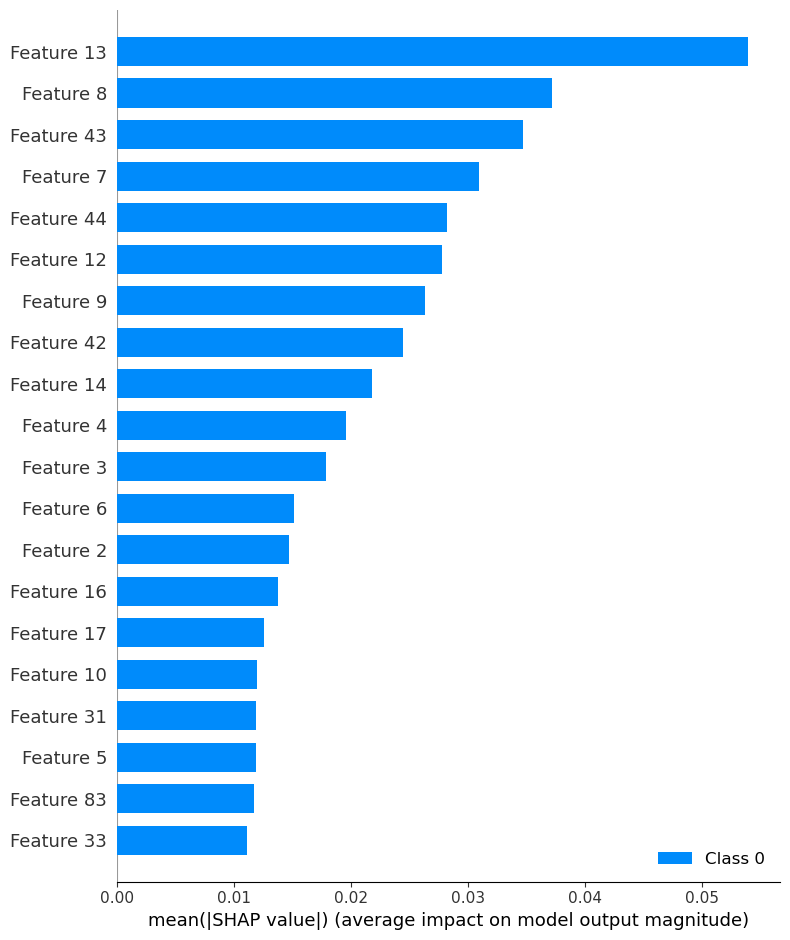

In [6]:
model = tf.keras.models.load_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/inception_l2_norm_all_data/inception_l2_norm_all_data_0_1_2_3/checkpoints/cp-0100/')

e = shap.KernelExplainer(model, X_3d[:, 2, 2])
shap_values = e.shap_values(X_3d[:, 2, 2])
shap.summary_plot(shap_values, X_3d[:, 2, 2], plot_type="bar")

In [ ]:
np.array(shap_values[0]).shape

<h1 style="text-align: center;"> Trying eli5 (another library for this) </h1>
Quite the same situation as with shap, 3D is not supported, but for 1D works and also shows importance of 13 and 14 feature

In [8]:
import eli5
from eli5.sklearn import PermutationImportance

#model = tf.keras.models.load_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/CV_3d_inception/3d_0_1_2_3/checkpoints/cp-0036/', custom_objects=config.CUSTOM_OBJECTS)
model = tf.keras.models.load_model('/home/sc.uni-leipzig.de/mi186veva/hsi-experiments/logs/inception_l2_norm_all_data/inception_l2_norm_all_data_0_1_2_3/checkpoints/cp-0100/')

perm = PermutationImportance(model, scoring='neg_mean_squared_error').fit(X_3d[:, 2, 2], y_3d)
eli5.show_weights(perm)

1/1 [==============================] - 0s 174ms/step


2023-05-24 21:52:27.589740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:27.590171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 54ms/step


2023-05-24 21:52:27.830660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:27.831097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:27.928517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:28.164675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:28.168639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:28.315512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:28.474189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:28.481653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:28.627708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 53ms/step


2023-05-24 21:52:28.689880: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:28.732276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:28.732730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:28.849382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:29.002639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.009590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.154117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:29.305762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.312958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.457828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:29.623693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.631235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.778325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:29.931425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:29.938909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.034693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:30.203496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.210677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.355748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:30.507115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.514309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.658742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:30.811460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.818674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:30.977717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 61ms/step


2023-05-24 21:52:31.123986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.124668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.261708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:31.414422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.421806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.566934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:52:31.719895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.727147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.857741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 53ms/step


2023-05-24 21:52:31.959847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:31.960526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:32.054071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 82ms/step


2023-05-24 21:52:32.301053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:32.301708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:32.350007: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:32.393101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 96ms/step


2023-05-24 21:52:32.571320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:32.571760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 43ms/step


2023-05-24 21:52:32.965457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:32.965889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.079495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:33.240137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.247397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.399079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:33.460047: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:33.519340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.519794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.645702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:33.804681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.811803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:33.971293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 68ms/step


2023-05-24 21:52:34.122164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.129324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.250480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 51ms/step


2023-05-24 21:52:34.398406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.399100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.511055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 84ms/step


2023-05-24 21:52:34.607274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.607929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.753296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:34.905118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:34.912364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.058020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:52:35.220734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.227833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.387723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:35.538883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.546109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.690172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 47ms/step


2023-05-24 21:52:35.856725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.857412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:35.901944: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:35.946050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:36.158013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:36.165327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:36.325266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:52:36.495570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:36.502668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:36.661752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:36.813476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:36.820743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:36.971450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 88ms/step


2023-05-24 21:52:37.123080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:37.130309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:37.274218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:52:37.443704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:37.451449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:37.601279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:37.757353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:37.764825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:37.911175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 48ms/step


2023-05-24 21:52:38.069986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.074492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.198523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 48ms/step


2023-05-24 21:52:38.295837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.302922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.434060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 44ms/step


2023-05-24 21:52:38.525848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.526504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.654509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 57ms/step


2023-05-24 21:52:38.775035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.775714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:38.822585: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:38.866616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 62ms/step


2023-05-24 21:52:38.993521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.000881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.126430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:39.280002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.287444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.431952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:39.560388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.560822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.721158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 45ms/step


2023-05-24 21:52:39.875769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:39.883135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.018031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:40.126355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.133269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.305627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:52:40.439157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.439675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.554884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 88ms/step


2023-05-24 21:52:40.645951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.650108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.808093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - ETA: 0s

2023-05-24 21:52:40.932641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:40.933307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.052883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 56ms/step


2023-05-24 21:52:41.195838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.196342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.324550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:41.483899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.490812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.645752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 95ms/step


2023-05-24 21:52:41.817933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.825829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:41.985503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:42.140823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.148284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.280469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:52:42.404943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.405378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.555278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:52:42.708541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.715749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.848446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:52:42.974844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:42.975499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.022035: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:43.064069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:52:43.316244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.316912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.429880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 70ms/step


2023-05-24 21:52:43.523130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.523754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.651629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 48ms/step


2023-05-24 21:52:43.805457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.812896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:43.940266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 52ms/step


2023-05-24 21:52:44.031837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.032490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.080242: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:44.122425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 62ms/step


2023-05-24 21:52:44.268383: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:44.310691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.311145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.432638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:44.604897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.612641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.739580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 46ms/step


2023-05-24 21:52:44.874135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:44.881336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.030521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:52:45.137574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.144634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.286711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 81ms/step


2023-05-24 21:52:45.451822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.452247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.575711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:45.733267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.733696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:45.884261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:46.038335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.045665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.208374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 56ms/step


2023-05-24 21:52:46.329895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.330331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.474343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 75ms/step


2023-05-24 21:52:46.597437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.597872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.733730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:46.886707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:46.893913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.050579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 84ms/step


2023-05-24 21:52:47.204548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.205209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.294630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 70ms/step


2023-05-24 21:52:47.427896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.435269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.572718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:47.740484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.747754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:47.894576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 68ms/step


2023-05-24 21:52:48.037989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.038655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.139777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:48.270025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.277225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.422888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:48.575188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.575618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.726261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:48.879403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:48.886597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.030451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:49.199814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.200273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.354465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:49.499099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.499614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.632339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 62ms/step


2023-05-24 21:52:49.772314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.772985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:49.871496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:50.006239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.006665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.106348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 61ms/step


2023-05-24 21:52:50.262571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.265122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.400610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:52:50.503209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.503870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.645177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:50.800719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.808256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:50.954377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 86ms/step


2023-05-24 21:52:51.084542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.085206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.129017: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:51.171782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 56ms/step


2023-05-24 21:52:51.319999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.320431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.457337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 64ms/step


2023-05-24 21:52:51.558859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.559514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.694548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:52:51.831648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.834991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:51.969832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 81ms/step


2023-05-24 21:52:52.072808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.073492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.200287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 85ms/step


2023-05-24 21:52:52.328124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.328793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.454981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:52:52.603855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.611124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.770865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:52.835465: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:52.884213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:52.891114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.025922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:52:53.143208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.143877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.186473: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:53.233413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:52:53.384940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.385374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.552789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:53.688691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.689371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.783991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 86ms/step


2023-05-24 21:52:53.942038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.942686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:53.991337: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:54.033835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:54.182624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.190038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.323344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:54.430581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.437682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.563576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 47ms/step


2023-05-24 21:52:54.727122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.727551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.859865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:54.991739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:54.999379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.146579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 87ms/step


2023-05-24 21:52:55.245780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.246901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.379771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 70ms/step


2023-05-24 21:52:55.535858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.538285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.660948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 61ms/step


2023-05-24 21:52:55.813035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.820346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:55.873028: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:55.927164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:56.080211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.087317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.231975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:56.384686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.391789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.567332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 57ms/step


2023-05-24 21:52:56.722709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.730225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.862663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:56.964982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:56.965649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.109576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:52:57.263606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.270998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.415401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:52:57.553428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.554087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.671954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 80ms/step


2023-05-24 21:52:57.812092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.812739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:57.859073: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:57.901160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:52:58.050864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:58.051552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:58.191329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:52:58.353506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:58.354177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:58.400951: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:58.446298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:52:58.681253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:58.688386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:58.847046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 51ms/step


2023-05-24 21:52:58.998499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.005702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.101313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:52:59.316404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.317065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.360394: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:59.411442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - ETA: 0s

2023-05-24 21:52:59.566686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.573387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.723089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:52:59.772342: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:52:59.815149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.815601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:52:59.944801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:00.114112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:00.121234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:00.266391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 95ms/step


2023-05-24 21:53:00.421061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:00.428404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:00.576205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:00.731237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:00.738655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:00.898342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 56ms/step


2023-05-24 21:53:01.058201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.065903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.201878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:53:01.332754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.333199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.474697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:01.623176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.630406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.774707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 62ms/step


2023-05-24 21:53:01.912237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.912887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:01.959565: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:02.001738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:02.140419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:02.140856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:02.292808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:02.421675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:02.422364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:02.469126: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:02.512633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:02.767070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:02.774371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:02.927730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 52ms/step


2023-05-24 21:53:02.986108: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:03.028646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.029112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.127226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:53:03.291704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.295159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.452997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:03.605481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.612923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.756885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 95ms/step


2023-05-24 21:53:03.925983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:03.926433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.097097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:53:04.211036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.218297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.359868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:04.450329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.451006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.500584: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:04.543270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:04.729287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.729953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.776478: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:04.818845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:53:04.974664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:04.981988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:05.125595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:05.305871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:05.306324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:05.461620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 57ms/step


2023-05-24 21:53:05.619324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:05.626852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:05.761725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 45ms/step


2023-05-24 21:53:05.879888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:05.880314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.013055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 67ms/step


2023-05-24 21:53:06.102901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.103570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.229919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:06.373803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.374467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.489844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 48ms/step


2023-05-24 21:53:06.658177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.658853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.705449: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:06.787285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 62ms/step


2023-05-24 21:53:06.947666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:06.948113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.070342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:53:07.237402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.244969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.373366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:07.483232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.490425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.651876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 60ms/step


2023-05-24 21:53:07.821476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.821923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:07.954877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:08.084402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.085068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.212418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 98ms/step


2023-05-24 21:53:08.317736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.318434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.415760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 95ms/step


2023-05-24 21:53:08.591836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.599242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.761176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:08.810868: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:08.865831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:08.872806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 60ms/step


2023-05-24 21:53:09.036740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.044005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.163541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:53:09.301546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.301988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.452032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:09.604165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.611481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.756288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 60ms/step


2023-05-24 21:53:09.943343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:09.950957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.001549: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:10.065188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 47ms/step


2023-05-24 21:53:10.229378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.236778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.373008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:53:10.483653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.484101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.636068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 56ms/step


2023-05-24 21:53:10.788177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.795468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:10.925969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:11.043205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.050259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.206363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:11.370465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.377923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.540911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:11.700063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.700502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.865442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 48ms/step


2023-05-24 21:53:11.977651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:11.978091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.111516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:53:12.223348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.230376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.378780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 47ms/step


2023-05-24 21:53:12.478275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.478943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.589882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:53:12.818406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.819071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:12.862967: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:12.914427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 57ms/step


2023-05-24 21:53:13.099091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.099757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.193179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:13.313940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.321457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.466719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:13.527203: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:13.590095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.596825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 57ms/step


2023-05-24 21:53:13.734764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.735396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.782078: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:13.824302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:53:13.955505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:13.962755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:14.137544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:53:14.267340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:14.268019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:14.388463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:14.552010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:14.559300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:14.720968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:53:14.891045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:14.891474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.041953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:53:15.180679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.181333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.280383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 48ms/step


2023-05-24 21:53:15.433956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.441494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.493172: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:15.535408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:53:15.648929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.790901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.791358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 54ms/step


2023-05-24 21:53:15.884598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.885271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:15.976500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 96ms/step


2023-05-24 21:53:16.089481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.251011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.258076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 51ms/step


2023-05-24 21:53:16.386690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.387368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.479578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 89ms/step


2023-05-24 21:53:16.594824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.595258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.746035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:16.898142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:16.905597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.069734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:53:17.226637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.227317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.275678: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:17.318770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 56ms/step


2023-05-24 21:53:17.445012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.452670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.587065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 78ms/step


2023-05-24 21:53:17.718892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.719547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.763505: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:17.811623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:17.937795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:17.945033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.105253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 51ms/step


2023-05-24 21:53:18.212266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.219301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.354215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:18.498068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.503533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.658751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:18.786325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.794010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:18.921577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 46ms/step


2023-05-24 21:53:19.081487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.081922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.235451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:53:19.326474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.327143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.449336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:53:19.603179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.610626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.732674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 68ms/step


2023-05-24 21:53:19.835408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.836066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:19.980596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 95ms/step


2023-05-24 21:53:20.137753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:20.145297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:20.294312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 96ms/step


2023-05-24 21:53:20.453066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:20.460564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:20.610131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:53:20.766706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:20.774173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:20.909369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 58ms/step


2023-05-24 21:53:21.011447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.012106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.129156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:21.281726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.289141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.343666: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:21.387276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 62ms/step


2023-05-24 21:53:21.564216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.564903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.614360: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:21.657855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:53:21.783540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.791295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:21.938217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:22.083489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.084009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.200280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:53:22.344669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.351767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.482340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:53:22.596953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.597388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.763188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 53ms/step


2023-05-24 21:53:22.911008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:22.911438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.026329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 49ms/step


2023-05-24 21:53:23.148085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.155360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.294482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 51ms/step


2023-05-24 21:53:23.389304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.389975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.484880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:53:23.724672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.731963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:23.875495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 94ms/step


2023-05-24 21:53:24.002870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.010172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.169536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:53:24.322763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.323428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.465090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 95ms/step


2023-05-24 21:53:24.622503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.630171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.778814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:24.936515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:24.944037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.078502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 90ms/step


2023-05-24 21:53:25.193155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.193587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.356145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 86ms/step


2023-05-24 21:53:25.511512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.518973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.573037: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:25.615799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 55ms/step


2023-05-24 21:53:25.753603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.754268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.802624: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:25.852392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 63ms/step


2023-05-24 21:53:25.959712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:25.960351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.095904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 61ms/step


2023-05-24 21:53:26.249093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.256470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.370455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:26.495438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.502485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.601628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:26.767979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.768411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:26.877715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:27.040358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.040790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.195288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:27.362201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.362893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.410720: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:27.467380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:27.616651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.619096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.774226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 87ms/step


2023-05-24 21:53:27.831103: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:27.873855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:27.878084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.022527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 92ms/step


2023-05-24 21:53:28.174566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.181877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.326155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 60ms/step


2023-05-24 21:53:28.428332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.428766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.564114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 91ms/step


2023-05-24 21:53:28.686129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.693432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:28.855814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 50ms/step


2023-05-24 21:53:29.030554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.031236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.075032: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:29.118535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:29.383125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.390609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.540698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 54ms/step


2023-05-24 21:53:29.704078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.711335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.760493: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:29.802855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:29.920970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:29.928309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:30.089201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 59ms/step


2023-05-24 21:53:30.172890: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled
2023-05-24 21:53:30.220943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:30.221399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:30.372500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

1/1 [==============================] - 0s 93ms/step


2023-05-24 21:53:30.528835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:30.536408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [14,92]
	 [[{{node Placeholder/_10}}]]
2023-05-24 21:53:30.683921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

1/1 [==============================] - 0s 93ms/step


Weight,Feature
0.2556 ± 0.0689,x59
0.2545 ± 0.1589,x57
0.2540 ± 0.1705,x58
0.2019 ± 0.2194,x14
0.1923 ± 0.0676,x54
0.1677 ± 0.2857,x55
0.1461 ± 0.2143,x38
0.1342 ± 0.2181,x27
0.1235 ± 0.1900,x13
0.1235 ± 0.1934,x42
